In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from konlpy.tag import Twitter
import pandas as pd
import numpy as np
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymongo
from sklearn.metrics import confusion_matrix, classification_report
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
import theano
import seaborn
import theano.tensor as T
import pickle
from IPython.core.display import display, HTML
from IPython.display import IFrame
from pivottablejs import pivot_ui
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.optimizers import *
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import sent_tokenize
%matplotlib inline

C:\Users\yjoun\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [140]:
client = pymongo.MongoClient('mongodb://localhost:27017/')

In [141]:
db = client.crawl_data
db.collection_names()

['keyword_rank', 'data', 'rel_keyword']

In [142]:
collection = db.data
collection2 = db.keyword_rank

In [13]:
item_df = pd.DataFrame(list(collection.find()))
keyword_df = pd.DataFrame(list(collection2.find()))

In [14]:
item_df.drop(['_id'], axis=1, inplace=True)
keyword_df.drop(['_id'], axis=1, inplace=True)

- 패션의류: 0
- 패션잡화: 1
- 화장품/미용: 2
- 디지털/가전: 3
- 가구/인테리어: 4
- 출산/육아: 5
- 스포츠/레저: 6
- 식품:7 
- 생활/건강: 8

In [32]:
item_df['catID'] = np.where(item_df.catID == '패션의류', 0, item_df.catID)
item_df['catID'] = np.where(item_df.catID == '패션잡화', 1, item_df.catID)
item_df['catID'] = np.where(item_df.catID == '화장품/미용', 2, item_df.catID)
item_df['catID'] = np.where(item_df.catID == '디지털/가전', 3, item_df.catID)
item_df['catID'] = np.where(item_df.catID == '가구/인테리어', 4, item_df.catID)
item_df['catID'] = np.where(item_df.catID == '출산/육아', 5, item_df.catID)
item_df['catID'] = np.where(item_df.catID == '스포츠/레저', 6, item_df.catID)
item_df['catID'] = np.where(item_df.catID == '식품', 7, item_df.catID)
item_df['catID'] = np.where(item_df.catID == '생활/건강', 8, item_df.catID)

In [34]:
keyword_df['catID'] = np.where(keyword_df.catID == '패션의류', 0, keyword_df.catID)
keyword_df['catID'] = np.where(keyword_df.catID == '패션잡화', 1, keyword_df.catID)
keyword_df['catID'] = np.where(keyword_df.catID == '화장품/미용', 2, keyword_df.catID)
keyword_df['catID'] = np.where(keyword_df.catID == '디지털/가전', 3, keyword_df.catID)
keyword_df['catID'] = np.where(keyword_df.catID == '가구/인테리어', 4, keyword_df.catID)
keyword_df['catID'] = np.where(keyword_df.catID == '출산/육아', 5, keyword_df.catID)
keyword_df['catID'] = np.where(keyword_df.catID == '스포츠/레저', 6, keyword_df.catID)
keyword_df['catID'] = np.where(keyword_df.catID == '식품', 7, keyword_df.catID)
keyword_df['catID'] = np.where(keyword_df.catID == '생활/건강', 8, keyword_df.catID)

C:\Users\yjoun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [83]:
catID = item_df['catID']
item_name = item_df['item_name']
catID = pd.DataFrame(np.append(catID, keyword_df['catID']))
item_name = pd.DataFrame(np.append(item_name, keyword_df['keywords']))
tmp_df = pd.DataFrame(np.append(catID, item_name, axis=1), columns=['catID','item_name'])
tmp_df = tmp_df.drop_duplicates(subset=['catID', 'item_name'], keep='first')
tmp_df['catID'] = tmp_df['catID'].astype('int64')

# Naive Bayes Multinormial 모델 만들기
- shallow learning

In [85]:
X_train, X_test, y_train, y_test = train_test_split(tmp_df['item_name'], tmp_df['catID'], test_size=0.1, random_state=0)

In [86]:
len(X_train), len(X_test), len(y_train), len(y_test)

(4398, 489, 4398, 489)

In [87]:
clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf',MultinomialNB(alpha=0.01)),
])

In [88]:
model = clf.fit(X_train, y_train)

In [89]:
y_pred = model.predict(X_test)

In [90]:
confusion_matrix(y_test, y_pred)

array([[58,  1,  0,  0,  0,  1,  0,  1,  0],
       [ 2, 48,  0,  0,  0,  1,  1,  0,  0],
       [ 8,  0, 27,  0,  0,  0,  1,  1,  1],
       [ 3,  0,  0, 55,  3,  1,  3,  2,  1],
       [ 9,  0,  0,  0, 39,  1,  2,  0,  3],
       [15,  3,  2,  1,  2, 45,  1,  0,  1],
       [13,  1,  0,  2,  2,  1, 25,  3,  4],
       [ 9,  3,  2,  0,  0,  1,  6, 24,  0],
       [ 9,  1,  2,  1,  4,  2,  1,  3, 27]], dtype=int64)

In [91]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.46      0.95      0.62        61
          1       0.84      0.92      0.88        52
          2       0.82      0.71      0.76        38
          3       0.93      0.81      0.87        68
          4       0.78      0.72      0.75        54
          5       0.85      0.64      0.73        70
          6       0.62      0.49      0.55        51
          7       0.71      0.53      0.61        45
          8       0.73      0.54      0.62        50

avg / total       0.75      0.71      0.71       489



In [92]:
pickle.dump(model, open("classification.plk", "wb"))

# 카테고리 분류 결과 확인

In [96]:
!echo python ..\flask_show\chart.py
IFrame('http://127.0.0.1:5000', width=1000, height=350)

python ..\flask_show\chart.py


# Keyword Rank DB 저장 (완료)

In [160]:
# cat_list = ['cloth', 'accessories', 'cosmetic', 'digital', 'furniture', 'babycare', 'sports', 'food', 'lifestyle',]
# keyword_df = pd.DataFrame()
# df = pd.DataFrame(columns=[ 'catID', 'rank', 'keywords', 'date', 'rel_record'])
# for idx, doc_name in enumerate(cat_list):
#     for doc_num in range(1, 101):
#         with open('C:/Users/yjoun/Desktop/datascience/final_project/final_project/data/'+doc_name+'/'+str(doc_num)+'.csv','rt',encoding='UTF-8') as fd:
#             reader = csv.reader(fd)
#             tmp_df = [row for row in reader]
#             tmp_df = pd.DataFrame(tmp_df[8:])
#             df['date'] = tmp_df[0][1:]
#             df['rel_record'] = tmp_df[1][1:]
#             df['catID'] = list(filter(lambda x: x!="", [cat if i == idx else "" for i, cat in enumerate (['패션의류', '패션잡화', '화장품/미용', '디지털/가전', '가구/인테리어', '출산/육아', '스포츠/레저', '식품', '생활/건강',])]))[0]
#             df['rank'] = doc_num
#             df['keywords'] = tmp_df[1][0]
#             keyword_df = keyword_df.append(df)
            

In [164]:
# client = pymongo.MongoClient("mongodb://localhost:27017/")
# client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [165]:
# db = client.crawl_data

In [166]:
# keyword_rank = client.crawl_data.keyword_rank

In [167]:
# keyword_df = keyword_df.to_dict('records')

In [168]:
# keyword_rank.insert_many(keyword_df)

In [169]:
# MONGO_QUERY = {}

In [170]:
# keyword_rank.find(MONGO_QUERY).count()

235800

In [98]:
db = client.crawl_data
db.collection_names()

['keyword_rank', 'data']

In [99]:
collection2 = db.keyword_rank
collection2

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'crawl_data'), 'keyword_rank')

In [102]:
keyword_df = pd.DataFrame(list(collection2.find()))

In [103]:
keyword_df.drop(['_id'], axis=1, inplace=True)

In [104]:
keyword_df['date'] = pd.to_datetime(keyword_df['date'])
keyword_df['rel_record'] = np.where(keyword_df['rel_record'] == None, 0.0, keyword_df['rel_record'])
keyword_df['rel_record'] = pd.to_numeric(keyword_df['rel_record'])

In [266]:
tmp = keyword_df[keyword_df['keywords'] == '그릇세트'].reset_index(drop=True)
tmp['catID'][0]

'생활/건강'

In [295]:
def kw_record_over_dt(keyword):
    tmp = []
    tmp = keyword_df[keyword_df['keywords'] == keyword].reset_index(drop=True)
    tmp.plot(x='date', y='rel_record', kind='line', figsize=(30,10))
    rc('font', family="NanumSquare")
    plt.title('categort: {}, keyword: {}, rank: {}'.format(tmp['catID'][0], keyword, tmp['rank'][0]))
    return plt.show()

C:\Users\yjoun\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumSquare'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


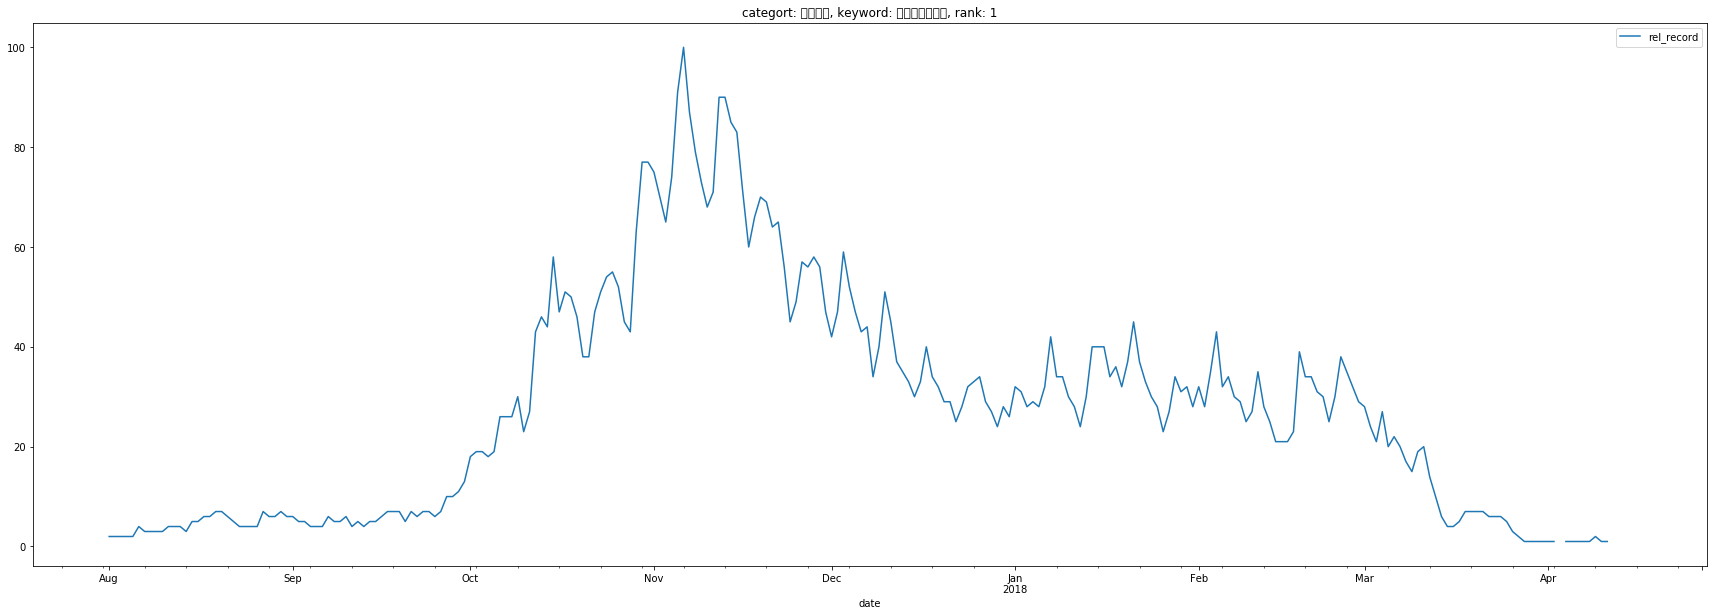

In [297]:
kw_record_over_dt('핸드메이드코트')

In [122]:
# key_list = keyword_df.keywords.unique()
# rel_keyword_df = pd.DataFrame(columns=['keyword'])
# for doc_name in key_list:
#     tmp_df = pd.read_excel('C:/Users/yjoun/Desktop/datascience/final_project/final_project/data/rel_keyword/'+str(doc_name)+'.xlsx',encoding='UTF-8', skiprows=0)
#     tmp_df['keyword'] = doc_name
#     rel_keyword_df = rel_keyword_df.append(tmp_df)

In [129]:
# rel_keyword_df.reset_index(drop=True, inplace=True)
# rel_keyword_df.columns = ['keyword', 'competancy', 'rel_keyword', 'monthly_click_pc', 'monthly_click_mobile', 'avg_montly_ad', 'avg_monthly_click_rate_pc', 'avg_monthly_click_rate_mobile', 'avg_monthly_click_pc', 'avg_monthly_click_mobile']

In [132]:
# rel_keyword = client.crawl_data.rel_keyword

In [133]:
# rel_keyword_df = rel_keyword_df.to_dict('records')

In [134]:
# rel_keyword.insert_many(rel_keyword_df)

In [136]:
# MONGO_QUERY = {}
# rel_keyword.find(MONGO_QUERY).count()

552953